### Notebook for analysing nf pipeline output

#### Sequencing batch 9

### Sequencing information 
 - Analysis no.: A003-service
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext FS and NEBNext
 - Seq Date: 30-04-2021
 - Number of samples:76

In [1]:
base_dir = '/home/douso/Kibet/2021-04-30_run6_KEM'

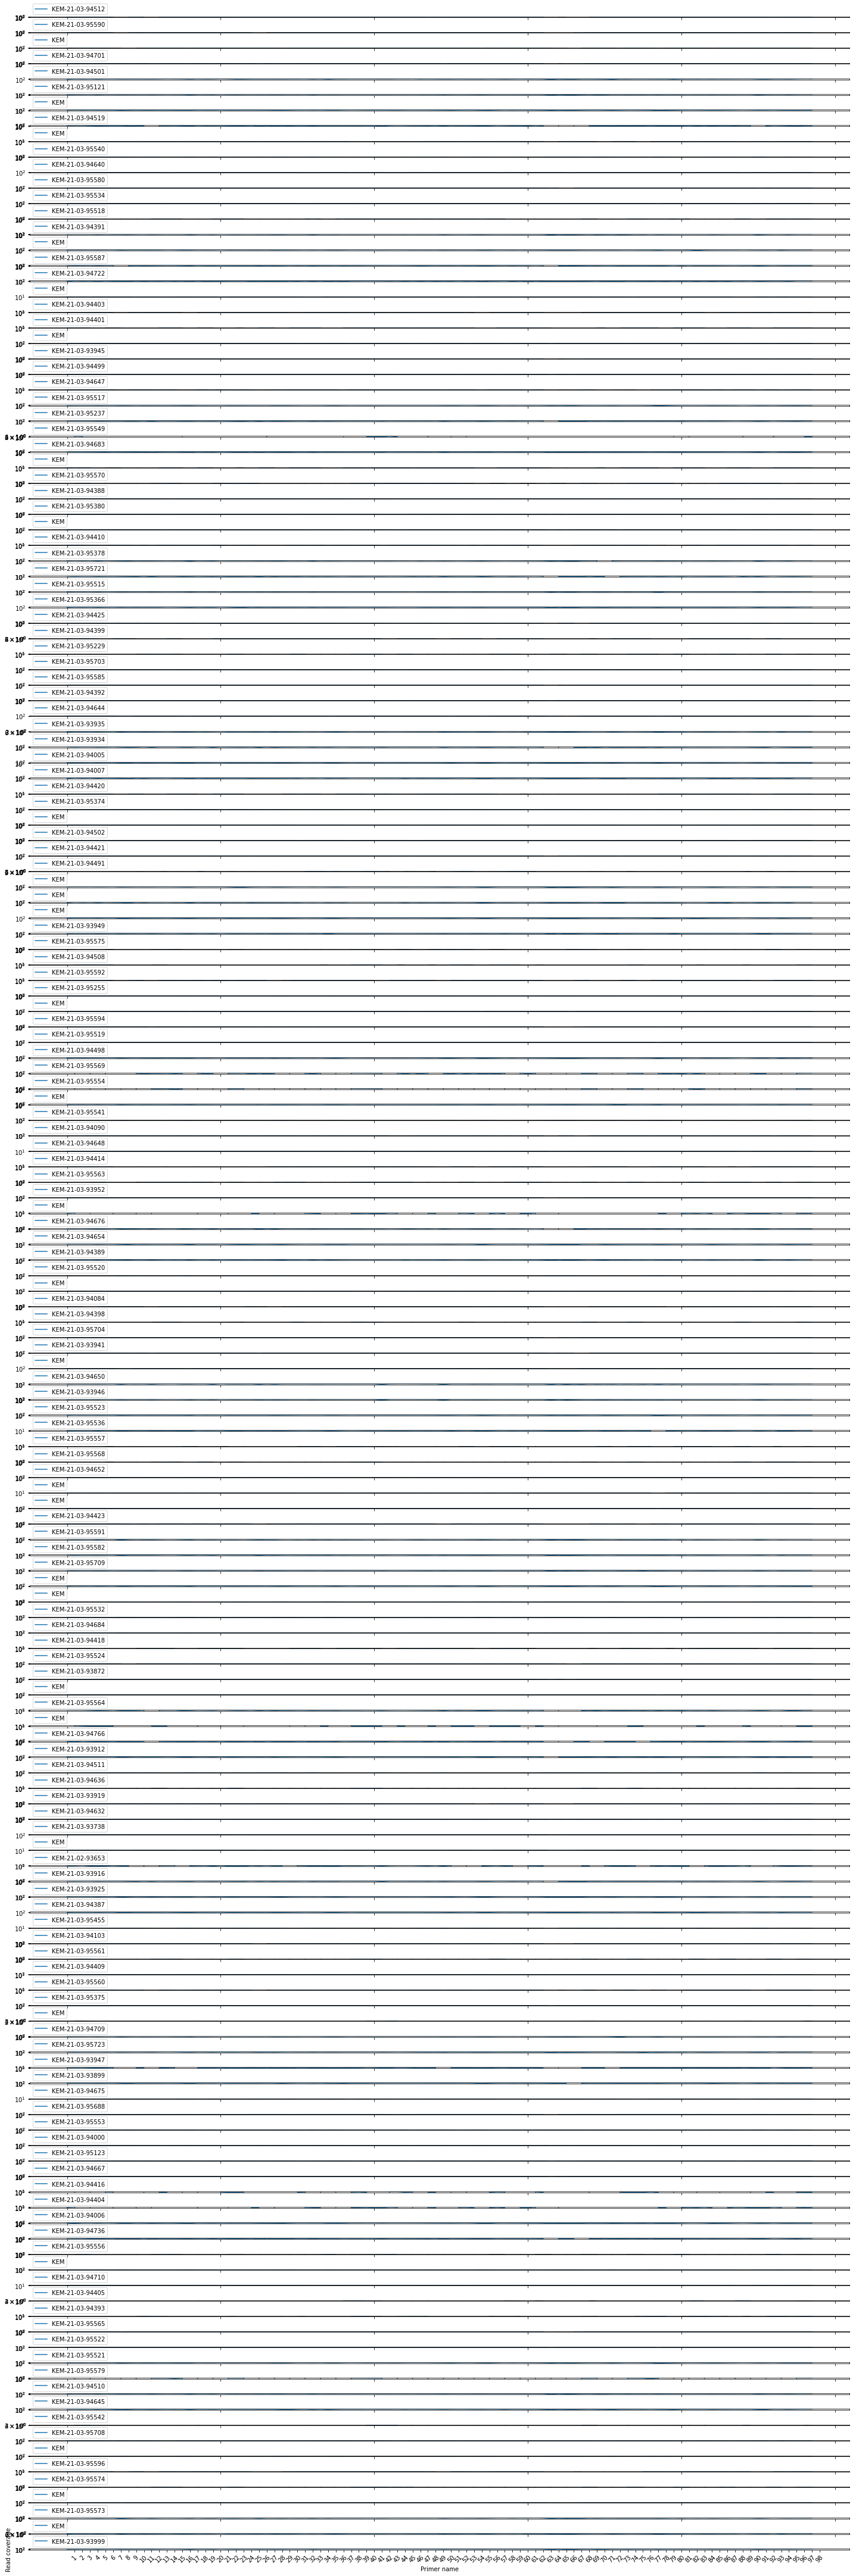

In [2]:
# plot primer depths across samples-GK
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os

suffix = '.amplicon.regions.coverage.tsv'
files = os.listdir(f'{base_dir}/dpt')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1
fig, axs = plt.subplots(a, b, figsize=(20,60)) 

xtick = np.arange(1, 99)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    sample_df = pd.read_table(f'{base_dir}/dpt/{file}')
    sample_df2 = sample_df[['region', 'coverage']]
    sample_df2.plot(logy=True, ax=axs[c], sharex=True, sharey=False) 
    axs[c].legend([sample_name], loc='lower left')
plt.xlabel('Primer name')
plt.ylabel('Read coverage')
plt.xticks(xtick, rotation=45)
plt.tight_layout()
plt.show()
#fig.savesample_df2fig('avg_kit_coverage2.png')


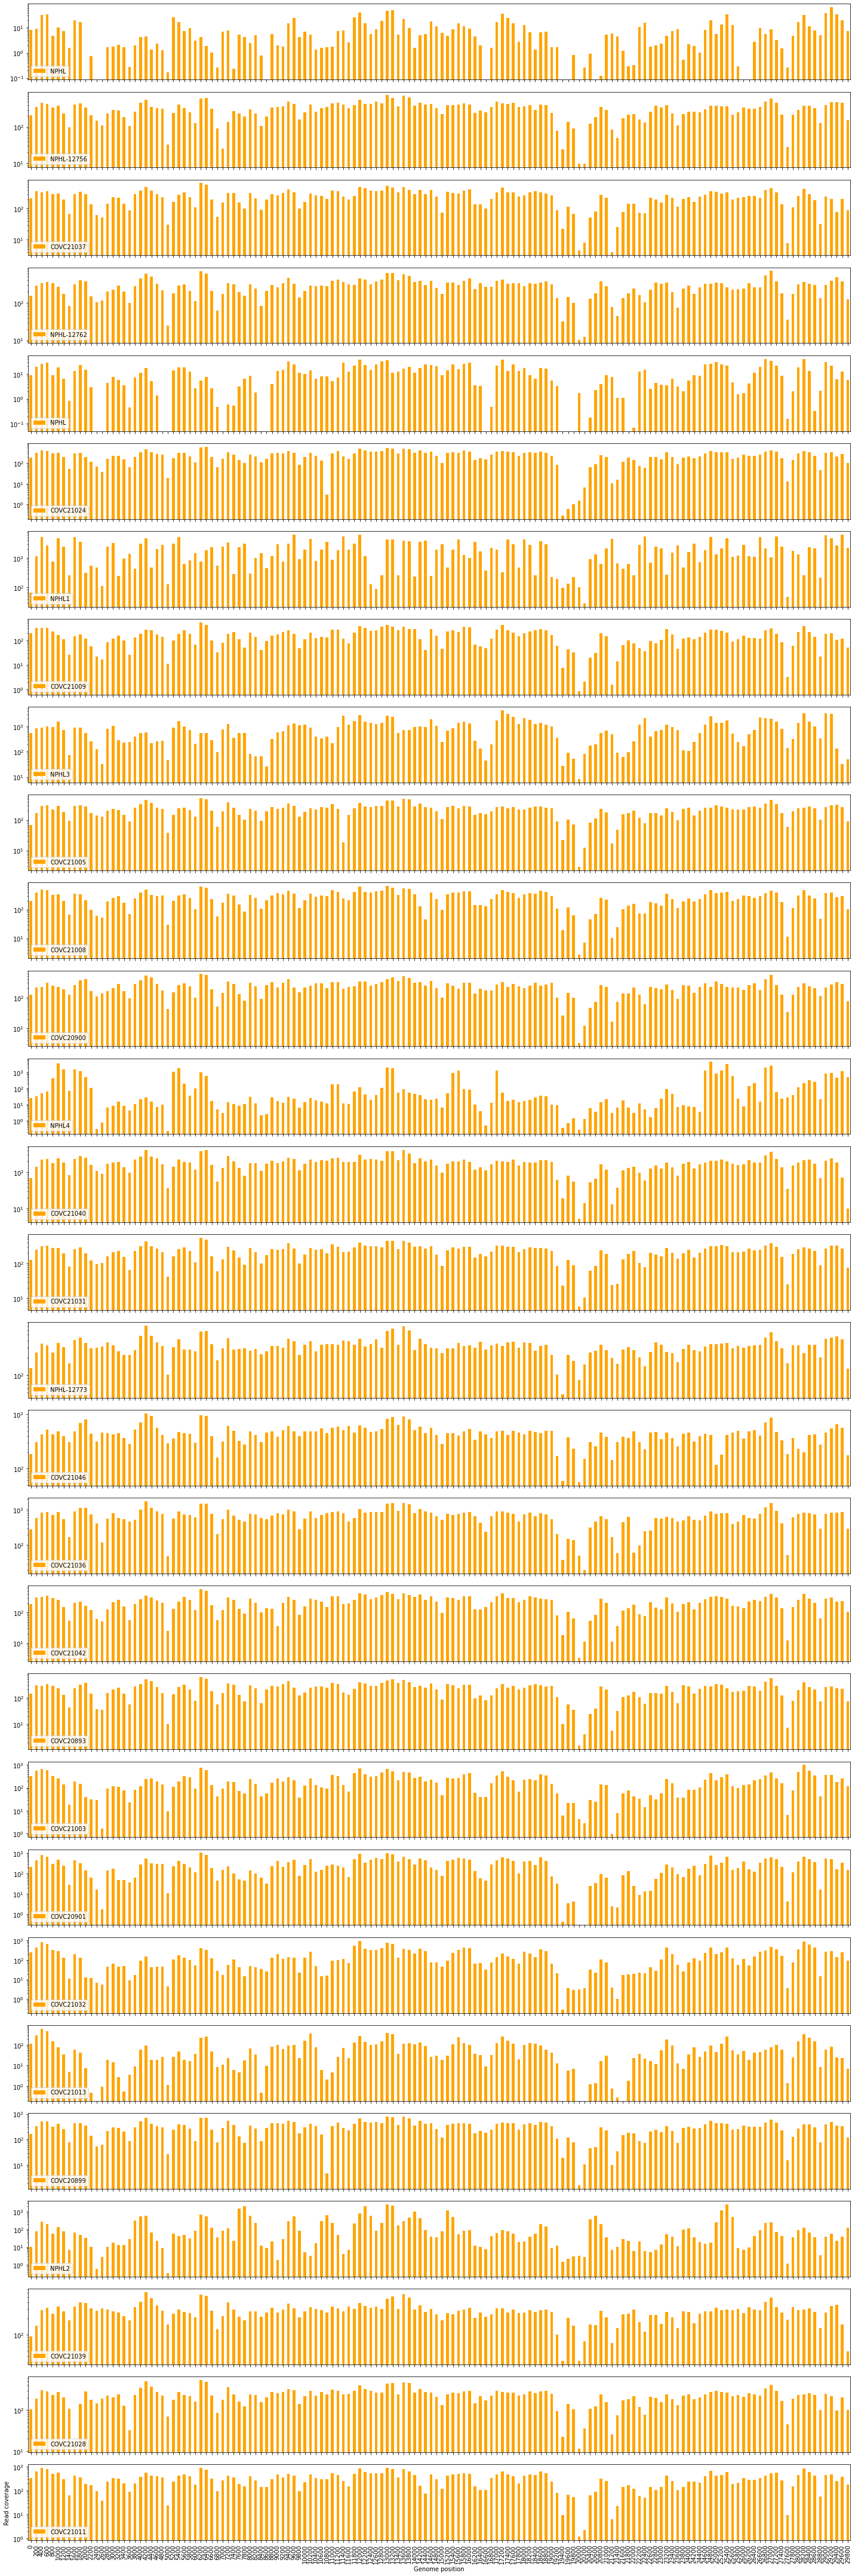

In [3]:
# plot read depths-GK
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt

suffix = '.genome.regions.coverage.tsv'
base_dir = '/home/douso/Kibet/2021-04-30_run6_NPHL_COVC/dpt'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1

fig, axs = plt.subplots(a, b, figsize=(20, 60))

xtick = range(0, 30000, 500)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    try:
        df1 = pd.read_table(f'{base_dir}/{file}')
        d = df1['coverage'].to_frame()
        d.set_index(np.arange(0, 30000, 200)).plot.bar(logy=True, ax=axs[c], sharex=True, color='orange')
        axs[c].legend([sample_name], loc='lower left')
        text = file.split('_')[1]
        plt.ylabel('Read coverage')
    except TypeError:
            print(f'no numeric data to plot for {file}')
    finally: pass
plt.xlabel('Genome position')
# plt.xticks(xtick, rotation=45)
plt.tight_layout()
plt.show()
#fig.savefig('avg_kit_coverage.png')

## Packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import glob, os

In [5]:
base_dir = '/home/douso/Kibet/2021-04-30_run6_KEM'
batch = 'seq9'
# dpt_dir = # ivar, samtools-depth output files
# nxt_dir = # nextclade .tsv output file
# png_dir = # pangolin .tsv output file
# var_dir = # snpEff ouput
# rmd_dir = # raw metadata - moh .xlsx spread sheet
#dpt var nxt png

## Analysis of batch 3 and 4 
### Sequencing information 
 - Analysis no.: NF-002-service (batch 9)
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext (FS and non-FS)
 - Seq Date: MiSeq (30-04-2021)
 - Number of samples: 150
 - Sample summ: KEM-21
 - VC pipeline: nextflow-viralcon

## Functions

In [6]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [7]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [8]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [9]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [10]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [11]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.merge(df_cts_cln, left_on='Sample_No', right_on='Sample_Name')
            .drop('Sample_Name', axis=1))


In [12]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('Sequence_name')
            .merge(df_rmdCts.set_index('Sample_number'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'Sequence_name'}))

In [13]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('_')[0]))
    return df_fnl

### Variants data

In [14]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(f'{base_dir}/var/k-per-gene_variant_anns.tsv')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: x.split('_')[0]))

In [15]:
print(df_var_fnl.shape)
df_var_fnl.head()
set1 = set(df_var_fnl['sample_name'])
set2 = set(df_var_fnl['sample_name'].unique())
print(set1 - set2)
print(set2 - set1)

(131, 17)
set()
set()


### Nextclade data

In [16]:
# import Nextclade clade data
df_nxt = pd.read_table(f'{base_dir}/nxt/run6_KEM_con.tsv')

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: x.split('_')[0]))
df_nxt_fnl = df_nxt_cln1.assign(coverage = coverage).drop('totalMissing', axis=1)

In [17]:
df_nxt_fnl['seqName'].unique()#.shape#head()
set1 = set(df_nxt_fnl['seqName'])
set2 = set(df_nxt_fnl['seqName'].unique())
print(set1 - set2)
print(set2 - set1)

set()
set()


### Pangolin data v.2.4.2 (25-04-2021)

In [18]:
# import Pangolin lineage data
df_png = pd.read_csv(f'{base_dir}/png/run6_KEM_con.pangolin.csv', header=0)
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Date_range', 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_cln1 = df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: x.split('_')[0]))
df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months)))

In [19]:
df_png_fnl['Sequence_name'].unique()#.shape#head()
set1 = set(df_png_fnl['Sequence_name'])
set2 = set(df_png_fnl['Sequence_name'].unique())
print(set1 - set2)
print(set2 - set1)

set()
set()


# Metadata

In [20]:
# import raw metadata file
import pandas as pd
mbase_dir = '/home/douso/Documents/TrendData/Results'
df_rmd = pd.read_excel(f'{mbase_dir}/seq-kemri-150samples.xlsx', header=1)

In [22]:
df_rmd.head()


PLATE NUMBER  S/No    Sample number SAMPLE TYPE (e.g. NP/OP, Blood)  \
0           A1   1.0  KEM-21-03-93738                    NP & OP Swab   
1           A2   2.0  KEM-21-03-93999                    NP & OP Swab   
2           A3   3.0  KEM-21-03-94391                    NP & OP Swab   
3           A4   4.0  KEM-21-03-94418                    NP & OP Swab   
4           A5   5.0  KEM-21-03-94511                    NP & OP Swab   

   OCCUPATION DATE OF SAMPLE COLLECTION  DATE SAMPLE RECEIVED IN THE LAB  \
0         NaN       2021-03-03 00:00:00                              NaN   
1         NaN                02/03/2021                              NaN   
2         NaN       2021-02-03 00:00:00                              NaN   
3         NaN                04/03/2021                              NaN   
4         NaN                09/03/2021                              NaN   

  LAB CONFIRMATION DATE Cycle threshold (Ct) value  Average_Ct  ...  \
0   2021-05-03 00:00:00                  18.2/19.3        18.8  ...   
1            10/03/2021                  22.3/18.6        20.5  ...   
2            11/03/2021                  26.1/21.3        23.7  ...   
3            11/03/2021                  11.4/21.5        16.5  ...   
4            11/03/2021                  26.3/28.0        27.2  ...   

  NATIONALITY HAS TRAVEL HOSTORY(LAST 14 DAYS) Y/N TRAVEL FROM  \
0       Kenya                                   No         NaN   
1       Kenya                                   No         NaN   
2       Kenya                                   No         NaN   
3       Kenya                                   No         NaN   
4       Kenya                                   No         NaN   

  QUARANTINE FACILITY/HOSPITAL/HOMESTEAD  COUNTY OF DIAGNOSIS  \
0                                    NaN              Kiambu    
1                                    NaN             Nairobi    
2                                    NaN               Kiambu   
3                                    NaN              Kiambu    
4                                    NaN             Nairobi    

  COUNTY OF RESIDENCE SUB COUNTY OF RESIDENCE        TESTING LAB  \
0             Kiambu                   Kahoho  KEMRI VHF/FLU LAB   
1             Kiambu               Githunguri  KEMRI VHF/FLU LAB   
2             Kiambu                   Thika   KEMRI VHF/FLU LAB   
3             Kiambu                    Thika  KEMRI VHF/FLU LAB   
4             Kiambu                    Thika  KEMRI VHF/FLU LAB   

  REASON FOR TESTING: 1. Surveillance  2. Air travel 3. Truck Driver 4. Others  \
0                                                1.0                             
1                                                1.0                             
2                                                1.0                             
3                                                1.0                             
4                                                1.0                             

     RESULT  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive  

[5 rows x 27 columns]

In [23]:
list(df_rmd.columns)

['PLATE NUMBER',
 'S/No',
 'Sample number',
 'SAMPLE TYPE (e.g. NP/OP, Blood)',
 'OCCUPATION',
 'DATE OF SAMPLE COLLECTION',
 'DATE SAMPLE RECEIVED IN THE LAB',
 'LAB CONFIRMATION DATE',
 'Cycle threshold (Ct) value',
 'Average_Ct',
 'INITIAL TESTING OR REPEAT TESTING',
 'HAVE SYMPTOMS Y/N',
 'DATE OF ONSET OF SYMPTOMS',
 'SYMTOMS SHOWN (COUGH;FEVER;ETC)',
 'AGE',
 'AGE UNIT (DAYS/MONTHS/YEARS)',
 'GENDER (M/F)',
 'NATIONALITY',
 'HAS TRAVEL HOSTORY(LAST 14 DAYS) Y/N',
 'TRAVEL FROM',
 'QUARANTINE FACILITY/HOSPITAL/HOMESTEAD',
 'COUNTY OF DIAGNOSIS',
 'COUNTY OF RESIDENCE',
 'SUB COUNTY OF RESIDENCE',
 'TESTING LAB',
 'REASON FOR TESTING: 1. Surveillance  2. Air travel 3. Truck Driver 4. Others',
 'RESULT']

In [24]:
cols = ['Sample_number',
 'AGE',
 'AGE_UNIT_(DAYS/MONTHS/YEARS)',
 'GENDER_(M/F)',
 'OCCUPATION',
 'NATIONALITY',
 'COUNTY_OF_RESIDENCE',
 'HAS_TRAVEL_HOSTORY(LAST_14_DAYS)_Y/N',
 'TRAVEL_FROM',
 'QUARANTINE_FACILITY/HOSPITAL/HOMESTEAD',
 'SYMTOMS_SHOWN_(COUGH;FEVER;ETC)',
 'DATE_OF_SAMPLE_COLLECTION',
 'DATE_SAMPLE_RECEIVED_IN_THE_LAB',
 'RESULT',
 'LAB_CONFIRMATION_DATE',
 'Average_Ct']
df_rmdCts = get_cols(tidy_header(df_rmd), cols)

In [25]:
df_rmdCts.shape

(152, 16)

### Combining data

#### Merge Variants and Nextclade data

In [26]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [27]:
df_varNxt.head()

sample_name  num_vars  \
0  KEM-21-02-93653       7.0   
1  KEM-21-03-93738      40.0   
2  KEM-21-03-93872      33.0   
3  KEM-21-03-93899      31.0   
4  KEM-21-03-93912      36.0   

                                              ORF1ab  ORF1a  \
0             K141_F143del, I1877M, L6549fs, L6549fs    NaN   
1  S216S, N615N, L766L, F924F, T1001I, A1708D, F1...    NaN   
2  S216S, L730F, F924F, T1001I, E1341D, A1708D, F...    NaN   
3  S216S, F924F, T1001I, A1708D, F1907F, S3675_F3...    NaN   
4  S216S, N615N, F924F, T1001I, A1708D, F1907F, I...    NaN   

                                                   S       ORF3a  ORF3b    E  \
0                                              Y636S  Q57H, W69S    NaN  NaN   
1  H69_V70del, Y145del, N501Y, A570D, D614G, P681...         NaN    NaN  NaN   
2  H69_V70del, Y145del, N501Y, A570D, D614G, P681...         NaN    NaN  NaN   
3  H69_V70del, Y145del, N501Y, A570D, D614G, P681...         NaN    NaN  NaN   
4  H69_V70del, Y145del, N501Y, A570D, D614G, P681...         NaN    NaN  NaN   

       M ORF6 ORF7a  ORF7b                    ORF8  \
0    NaN  NaN   NaN    NaN                     NaN   
1    NaN  NaN   NaN    NaN  Q27*, R52I, K68*, Y73C   
2  T175T  NaN   NaN    NaN        Q27*, R52I, Y73C   
3    NaN  NaN   NaN    NaN  Q18H, Q27*, R52I, Y73C   
4    NaN  NaN   NaN    NaN  Q27*, R52I, K68*, Y73C   

                                                  N  ORF9a  ORF9b  ORF10  \
0                                               NaN    NaN    NaN    NaN   
1  D3H, D3V, D3E, T135I, R203K, R203R, G204R, S235F    NaN    NaN    NaN   
2         D3H, D3V, D3E, R203K, R203R, G204R, S235F    NaN    NaN    NaN   
3         D3H, D3V, D3E, R203K, R203R, G204R, S235F    NaN    NaN    NaN   
4  D3H, D3V, D3E, R203K, R203R, G204R, S235F, D288D    NaN    NaN    NaN   

         clade  coverage  
0          19A      28.4  
1  20I/501Y.V1      99.5  
2  20I/501Y.V1      95.6  
3  20I/501Y.V1      92.5  
4  20I/501Y.V1      96.7

#### Merge pango and var-nextclade data

In [28]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [29]:
df_pngVxt#head()

Sequence_name  Lineage      Date_range      Most_common_countries  \
0    KEM-21-02-93653      NaN             NaN                        NaN   
1    KEM-21-03-93738  B.1.1.7  Sep-20, Feb-21        UK, Denmark, France   
2    KEM-21-03-93872  B.1.1.7  Sep-20, Feb-21        UK, Denmark, France   
3    KEM-21-03-93899  B.1.1.7  Sep-20, Feb-21        UK, Denmark, France   
4    KEM-21-03-93912  B.1.1.7  Sep-20, Feb-21        UK, Denmark, France   
..               ...      ...             ...                        ...   
130  KEM-21-03-95704  B.1.1.7  Sep-20, Feb-21        UK, Denmark, France   
131  KEM-21-03-95708  B.1.1.7  Sep-20, Feb-21        UK, Denmark, France   
132  KEM-21-03-95709  B.1.351  Sep-28, Feb-12  South_Africa, UK, Belgium   
133  KEM-21-03-95721  B.1.525  Dec-28, Feb-09       UK, Denmark, Nigeria   
134  KEM-21-03-95723  B.1.351  Sep-28, Feb-12  South_Africa, UK, Belgium   

     num_vars                                             ORF1ab  ORF1a  \
0         7.0             K141_F143del, I1877M, L6549fs, L6549fs    NaN   
1        40.0  S216S, N615N, L766L, F924F, T1001I, A1708D, F1...    NaN   
2        33.0  S216S, L730F, F924F, T1001I, E1341D, A1708D, F...    NaN   
3        31.0  S216S, F924F, T1001I, A1708D, F1907F, S3675_F3...    NaN   
4        36.0  S216S, N615N, F924F, T1001I, A1708D, F1907F, I...    NaN   
..        ...                                                ...    ...   
130      35.0  R24R, S216S, F924F, T1001I, A1708D, F1907F, S3...    NaN   
131      41.0  S216S, N615N, N810N, F924F, T1001I, A1708D, F1...    NaN   
132      26.0  T265I, T809T, F924F, K1655N, K3353R, S3675_F36...    NaN   
133      31.0  F411F, G514G, K798K, T2007I, V2776V, F3100F, V...    NaN   
134      29.0  T265I, T809T, F924F, K1655N, K3353R, L3606F, S...    NaN   

                                                     S  \
0                                                Y636S   
1    H69_V70del, Y145del, N501Y, A570D, D614G, P681...   
2    H69_V70del, Y145del, N501Y, A570D, D614G, P681...   
3    H69_V70del, Y145del, N501Y, A570D, D614G, P681...   
4    H69_V70del, Y145del, N501Y, A570D, D614G, P681...   
..                                                 ...   
130  H69_V70del, Y145del, N501Y, A570D, E583D, D614...   
131  H69_V70del, Y145del, N501Y, A570D, D614G, P681...   
132  L18F, D80A, D215G, L242_L244del, P384L, K417N,...   
133  Y145del, W152R, E484K, D614G, Q677H, F888L, F1...   
134  L18F, D80A, D215G, L242_L244del, P384L, K417N,...   

                         ORF3a  ORF3b  ...   ORF6 ORF7a ORF7b  \
0                   Q57H, W69S    NaN  ...    NaN   NaN   NaN   
1                          NaN    NaN  ...    NaN   NaN   NaN   
2                          NaN    NaN  ...    NaN   NaN   NaN   
3                          NaN    NaN  ...    NaN   NaN   NaN   
4                          NaN    NaN  ...    NaN   NaN   NaN   
..                         ...    ...  ...    ...   ...   ...   
130                        NaN    NaN  ...    NaN   NaN   NaN   
131                        NaN    NaN  ...    NaN   NaN   NaN   
132  Q57H, W131L, S171L, G254*    NaN  ...    NaN   NaN   NaN   
133                        NaN    NaN  ...  F2del   NaN   NaN   
134  Q57H, W131L, S171L, G254*    NaN  ...    NaN   NaN   NaN   

                       ORF8                                                 N  \
0                       NaN                                               NaN   
1    Q27*, R52I, K68*, Y73C  D3H, D3V, D3E, T135I, R203K, R203R, G204R, S235F   
2          Q27*, R52I, Y73C         D3H, D3V, D3E, R203K, R203R, G204R, S235F   
3    Q18H, Q27*, R52I, Y73C         D3H, D3V, D3E, R203K, R203R, G204R, S235F   
4    Q27*, R52I, K68*, Y73C  D3H, D3V, D3E, R203K, R203R, G204R, S235F, D288D   
..                      ...                                               ...   
130  Q27*, R52I, K68*, Y73C         D3H, D3V, D3E, R203K, R203R, G204R, S235F   
131  Q27*, R52I, K68*, Y73C         D3H, D3V, D3E, R203K, R203R, G2

#### Merge the metadata and Cts data

In [31]:
df_rmdCts.head()

Sample_number   AGE AGE_UNIT_(DAYS/MONTHS/YEARS) GENDER_(M/F)  \
0  KEM-21-03-93738  42.0                        Years            F   
1  KEM-21-03-93999  55.0                        Years            F   
2  KEM-21-03-94391  70.0                        Years            F   
3  KEM-21-03-94418  31.0                        Years            F   
4  KEM-21-03-94511  18.0                        Years            M   

   OCCUPATION NATIONALITY COUNTY_OF_RESIDENCE  \
0         NaN       Kenya             Kiambu    
1         NaN       Kenya             Kiambu    
2         NaN       Kenya             Kiambu    
3         NaN       Kenya             Kiambu    
4         NaN       Kenya             Kiambu    

  HAS_TRAVEL_HOSTORY(LAST_14_DAYS)_Y/N TRAVEL_FROM  \
0                                   No         NaN   
1                                   No         NaN   
2                                   No         NaN   
3                                   No         NaN   
4                                   No         NaN   

   QUARANTINE_FACILITY/HOSPITAL/HOMESTEAD SYMTOMS_SHOWN_(COUGH;FEVER;ETC)  \
0                                     NaN                             NaN   
1                                     NaN                General weakness   
2                                     NaN                             NaN   
3                                     NaN                             NaN   
4                                     NaN                   Loss of taste   

  DATE_OF_SAMPLE_COLLECTION  DATE_SAMPLE_RECEIVED_IN_THE_LAB    RESULT  \
0       2021-03-03 00:00:00                              NaN  Positive   
1                02/03/2021                              NaN  Positive   
2       2021-02-03 00:00:00                              NaN  Positive   
3                04/03/2021                              NaN  Positive   
4                09/03/2021                              NaN  Positive   

  LAB_CONFIRMATION_DATE  Average_Ct  
0   2021-05-03 00:00:00        18.8  
1            10/03/2021        20.5  
2            11/03/2021        23.7  
3            11/03/2021        16.5  
4            11/03/2021        27.2

#### Merge sequence/var-nxt-png (pngVxt) and  processed metadata (rmdCts)

In [32]:
# merge processed metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmdCts)

In [33]:
df_vnpPmd.head()


Sequence_name Lineage Date_range Most_common_countries  num_vars  \
0  KEM-012-IMC-004-12773     NaN        NaN                   NaN       NaN   
1  KEM-012-IMC-557-12780     NaN        NaN                   NaN       NaN   
2  KEM-012-IMH-533-12756     NaN        NaN                   NaN       NaN   
3  KEM-012-IMN-538-12761     NaN        NaN                   NaN       NaN   
4  KEM-012-IMN-539-12762     NaN        NaN                   NaN       NaN   

  ORF1ab  ORF1a    S ORF3a  ORF3b  ... COUNTY_OF_RESIDENCE  \
0    NaN    NaN  NaN   NaN    NaN  ...                 NaN   
1    NaN    NaN  NaN   NaN    NaN  ...                 NaN   
2    NaN    NaN  NaN   NaN    NaN  ...                 NaN   
3    NaN    NaN  NaN   NaN    NaN  ...                 NaN   
4    NaN    NaN  NaN   NaN    NaN  ...                 NaN   

  HAS_TRAVEL_HOSTORY(LAST_14_DAYS)_Y/N TRAVEL_FROM  \
0                                  NaN         NaN   
1                                  NaN         NaN   
2                                  NaN         NaN   
3                                  NaN         NaN   
4                                  NaN         NaN   

  QUARANTINE_FACILITY/HOSPITAL/HOMESTEAD  SYMTOMS_SHOWN_(COUGH;FEVER;ETC)  \
0                                    NaN                              NaN   
1                                    NaN                              NaN   
2                                    NaN                              NaN   
3                                    NaN                              NaN   
4                                    NaN                              NaN   

  DATE_OF_SAMPLE_COLLECTION DATE_SAMPLE_RECEIVED_IN_THE_LAB  RESULT  \
0                       NaN                             NaN     NaN   
1                       NaN                             NaN     NaN   
2                       NaN                             NaN     NaN   
3                       NaN                             NaN     NaN   
4                       NaN                             NaN     NaN   

   LAB_CONFIRMATION_DATE  Average_Ct  
0                    NaN         NaN  
1                    NaN         NaN  
2                    NaN         NaN  
3                    NaN         NaN  
4                    NaN         NaN  

[5 rows x 37 columns]

#### QC whether all samples sequenced had metadata

In [34]:
codes_fnl = set(df_vnpPmd['Sequence_name'])
codes_metadata = set(df_rmdCts['Sample_number'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
set()


These sample codes were in the sequencing data but not on the metadata. `NPHLs` didn't have metadata
 - NPHL3
 - NPHL4
 - NPHL2
 - NPHL-12773
 - NPHL1
 - NPHL-12756

#### Re-order df_vnpPmd columns and export merged metadata and sequencing data

In [35]:
df_vnpPmd.columns

Index(['Sequence_name', 'Lineage', 'Date_range', 'Most_common_countries',
       'num_vars', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade',
       'coverage', 'AGE', 'AGE_UNIT_(DAYS/MONTHS/YEARS)', 'GENDER_(M/F)',
       'OCCUPATION', 'NATIONALITY', 'COUNTY_OF_RESIDENCE',
       'HAS_TRAVEL_HOSTORY(LAST_14_DAYS)_Y/N', 'TRAVEL_FROM',
       'QUARANTINE_FACILITY/HOSPITAL/HOMESTEAD',
       'SYMTOMS_SHOWN_(COUGH;FEVER;ETC)', 'DATE_OF_SAMPLE_COLLECTION',
       'DATE_SAMPLE_RECEIVED_IN_THE_LAB', 'RESULT', 'LAB_CONFIRMATION_DATE',
       'Average_Ct'],
      dtype='object')

In [36]:
header_kem = ['Sequence_name','AGE','AGE_UNIT_(DAYS/MONTHS/YEARS)',
 'GENDER_(M/F)','OCCUPATION','NATIONALITY','COUNTY_OF_RESIDENCE',
 'HAS_TRAVEL_HOSTORY(LAST_14_DAYS)_Y/N','TRAVEL_FROM',
 'QUARANTINE_FACILITY/HOSPITAL/HOMESTEAD','SYMTOMS_SHOWN_(COUGH;FEVER;ETC)',
 'DATE_OF_SAMPLE_COLLECTION','DATE_SAMPLE_RECEIVED_IN_THE_LAB',
 'RESULT','LAB_CONFIRMATION_DATE','Average_Ct', 'Lineage',
  'Most_common_countries', 'Date_range', 
  'clade', 'coverage', 'num_vars', 'S', 'ORF1ab', 'ORF1a', 'ORF3a', 
  'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 
  'ORF9b', 'ORF10']

In [37]:
cols_rename = ['S_NUM', 'AGE', 'AGE_UNIT', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'M_COMM_C', 'DT_RANG', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [38]:
df_vnpPmd_fnl = df_vnpPmd[header_kem]
df_vnpPmd_fnl.columns = cols_rename
# df_vnpPmd_fnl.to_excel('/home/douso/SarsGenomics/Processed/metadata-serv-seq-MS001.xlsx'
#                      , index=False, na_rep='NA', float_format='%.1f', header=cols_rename)
df_vnpPmd_fnl.shape

(152, 37)

In [39]:
clr_code = {'B.1.1.7': ('orange', '#FFA500'),
            'B.1.525': ('green', '#008000'), 
            'B.1.351': ('blue', '#0000FF'),
            'B.1.549': ('brown', '#A52A2A'),
            'A.23.1': ('gray', '#808080'),
            'B.1.596.1': ('magenta', '#FF00FF'),
            'B.1': ('cyan', '#00FFFF'),
            'B.1.530': ('red', '#FF0000'),
            'A.23': ('lime', '#00FF00'),
            'B.1.143': ('olive', '#808000'),
            'B.1.1.171': ('teal', '#008080'),
            'B.1.343': ('indigo', '#4B0082'),
            'B.1.388': ('sienna', '#A0522D'),
            'TBA1': ('sienna', '#A0522D'),
            'TBA2': ('chocolate', '#D2691E'),
            'TBA3': ('chocolate', '#D2691E'),
            'TBA3': ('rosybrown', '#BC8F8F'),
            'TBA4': ('wheat', '#F5DEB3'),
            'TBA5': ('slategray', '#708090'),
            'TBA6': ('palevioletred', '#DB7093'),
            'TBA7': ('mediumpurple', '#9370DB'),
            'TBA8': ('tan', '#D2B48C'),
            'TBA9': ('aquamarine', '#7FFFD4')}

clr_lin = {'B.1.1.7': '#FFA500', 'B.1.525': '#008000', 'B.1.351': '#0000FF'
            , 'B.1.549': '#A52A2A', 'A.23.1': '#808080', 'B.1.596.1': '#FF00FF',
       'B.1': '#00FFFF', 'B.1.530': '#FF0000', 'A.23': '#00FF00', 'B.1.143': '#808000', 
       'B.1.1.171': '#008080', 'B.1.343': '#4B0082', 'B.1.388': '#A0522D'}

In [40]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

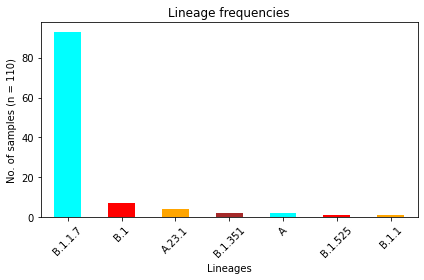

In [41]:
# plot lineage frequencies
colors = ['#00FFFF', '#FF0000', '#FFA500', '#A52A2A']
n = df_vnpPmd_fnl[df_vnpPmd_fnl['LIN'].isna() == False]['LIN'].count()
fig, ax = plt.subplots()
(df_vnpPmd_fnl[df_vnpPmd_fnl['LIN'].isna() == False]['LIN']
 .value_counts()
 .plot(kind='bar', ax=ax, color=colors))
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.xticks(rotation=45)
plt.ylabel(f'No. of samples (n = {n})')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P003.png', dpi=300.0)
plt.show()